In [1]:
import gc
import os
import warnings
import inspect
import tqdm

from pathlib import Path

In [2]:
warnings.filterwarnings('ignore')
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoConfig, AutoTokenizer, AutoModel

import bioframe as bf
import bioframe.vis
from Bio import SeqIO

In [4]:
import sys 
sys.path.append("../")
from dnalm.downstream_tasks.promoter_prediction.dataset import EPDnewPromoterDataset
from dnalm.src.gena_lm.modeling_bert import BertForSequenceClassification

In [5]:
DEVICE=0
PROMOTERS_PATH="human_epdnew_fH7d2.bed"
CLINVAR_PATH="clinvar_reg.tsv"
TOKENIZER_PATH="/mnt/10tb/home/penzar/dnabert_tokenizers/t2t_1000h_multi_32k/"
MODEL_CFG_PATH="/mnt/10tb/home/penzar/dnabert_configs/L24-H1024-A16-V32k-preln-lastln.json"
MODEL_WEIGHT_PATH="/mnt/10tb/home/penzar/GENALM/DIMA_promoters_2000/large/model_best.pth"

In [6]:
epdnew = pd.read_table(PROMOTERS_PATH, header=None, names=["chrom", "start", "end", "name", "length", "strand"])

In [7]:
def extend(row, lbord, rbord):
    strand = row.strand 
    start = row.start
    end = row.end
    if strand == "+":
        lpos = start-lbord
        rpos = end+rbord
    elif strand == "-":
        lpos= start - rbord
        rpos = end + lbord
    else:
        raise Exception(f"Wrong strand: {strand}")
    row.start = lpos
    row.end = rpos 
    return row 
proms = epdnew.apply(lambda x: extend(x, 1000, 999), axis=1)

In [8]:
genome = SeqIO.to_dict(SeqIO.parse("hg38.fa", format="fasta"))

In [9]:
device = torch.device(f"cuda:{DEVICE}" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH)
model_cfg = AutoConfig.from_pretrained(MODEL_CFG_PATH)
model = BertForSequenceClassification(model_cfg).to(device)

light_dict = torch.load(MODEL_WEIGHT_PATH, map_location="cpu")
model.load_state_dict(
    light_dict['model_state_dict'])

model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 1024, padding_idx=3)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (pre_attention_ln): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (post_attention_ln): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
          

In [10]:
clinvar_no_exons = pd.read_table('clinvar_reg.tsv')
clinvar_prom_overlap = bf.overlap(clinvar_no_exons, proms,  how="left", suffixes=("", "_prom"))
clinvar_prom_overlap = clinvar_prom_overlap[~pd.isnull(clinvar_prom_overlap.chrom_prom)]
clinvar_prom_overlap = clinvar_prom_overlap.rename({'start': 'mut_start', "end": "mut_end"}, axis=1)
autosomes = set(f'chr{i}' for i in range(1, 22+1))
clinvar_prom_overlap = clinvar_prom_overlap[clinvar_prom_overlap.chrom.isin(autosomes)]

mask = clinvar_prom_overlap['alt'].str.len() == clinvar_prom_overlap['ref'].str.len() 

mask = np.logical_and(clinvar_prom_overlap['alt'].str.len() == 1,
                      clinvar_prom_overlap['ref'].str.len() == 1)
clinvar_prom_overlap = clinvar_prom_overlap[mask]

In [11]:
clinvar_prom_overlap.head()

,chrom,mut_start,mut_end,ref,alt,clinvar_id,omim_ids,gene_info,consequences,significance,stats,chrom_prom,start_prom,end_prom,name_prom,length_prom,strand_prom
2,chr1,1013489,1013490,C,G,1185393,616126,ISG15:9636,NaN,benign,criteria_provided;_multiple_submitters;_no_con...,chr1,1012496,1014496,ISG15_1,1.0,+
69,chr1,2412602,2412603,G,C,1215376,NaN,PEX10:5192,SO:0001627|intron_variant,benign,criteria_provided;_multiple_submitters;_no_con...,chr1,2411543,2413543,PEX10_1,1.0,-
141,chr1,6468598,6468599,G,A,513202,611067;615376,PLEKHG5:57449,SO:0001627|intron_variant,benign,criteria_provided;_multiple_submitters;_no_con...,chr1,6468123,6470123,TNFRSF25_2,1.0,-
142,chr1,6469687,6469688,G,T,297954,611067;615376,PLEKHG5:57449,SO:0001627|intron_variant,benign,criteria_provided;_multiple_submitters;_no_con...,chr1,6468123,6470123,TNFRSF25_2,1.0,-
143,chr1,6469691,6469692,G,T,513060,611067;615376,PLEKHG5:57449,SO:0001627|intron_variant,benign,criteria_provided;_multiple_submitters;_no_con...,chr1,6468123,6470123,TNFRSF25_2,1.0,-


In [12]:
seq_records = []

for _, row in clinvar_prom_overlap.iterrows(): 
    alt = row.alt if not pd.isnull(row.alt) else ""

    # check reference genome correctness 
    assert row.ref == genome[row.chrom][row.mut_start:row.mut_end].seq.upper()   
    
    if row.strand_prom == "+":
        ref_sr =  genome[row.chrom][row.start_prom:row.end_prom].upper()
        alt_sr = genome[row.chrom][row.start_prom:row.mut_start] + alt + genome[row.chrom][row.mut_end:row.end_prom]
        alt_sr = alt_sr.upper()
    elif row.strand_prom == "-":
        lpos= row.start_prom
        rpos = row.end_prom
        ref_sr = genome[row.chrom][lpos:rpos].upper().reverse_complement()
       
        alt_sr = genome[row.chrom][row.start_prom:row.mut_start] + alt + genome[row.chrom][row.mut_end:row.end_prom]
        alt_sr = alt_sr.upper().reverse_complement()
    else:
        raise Exception(f"Wrong strand: {strand}")
    ref_sr.id = ref_sr.name = row.name 
    alt_sr.id = alt_sr.name = row.name 

    assert len(alt_sr.seq) == len(alt) - len(row.ref) + 2000
    

    seq_records.append( (ref_sr, alt_sr) )

In [13]:
def to_probs(logits):
    exps = logits.exp()
    probs = exps / exps.sum()
    return probs
    
def predict_clinvar_diff(ref: str, alt: str) -> float:
    ref_X = tokenizer(str(ref), return_tensors='pt')
    ref_X = {key: value.to(device) for key, value in ref_X.items()}
    alt_X = tokenizer(str(alt), return_tensors='pt')
    alt_X = {key: value.to(device) for key, value in alt_X.items()}

    with torch.inference_mode():
        ref_y = model(**ref_X).logits.cpu()
        alt_y = model(**alt_X).logits.cpu()

    ref_probs = to_probs(ref_y) 
    alt_probs = to_probs(alt_y)

    ref_logodds = torch.log(ref_probs[0][1] / ref_probs[0][0])
    alt_logodds = torch.log(alt_probs[0][1] / alt_probs[0][0])

    dif_logods = ref_logodds - alt_logodds
    return dif_logods

In [14]:
diffs = []
for ref, alt in tqdm.tqdm(seq_records):
    dif = predict_clinvar_diff(str(ref.seq),
                               str(alt.seq))
    diffs.append(dif)


100%|███████████████████████████████████████████████████████████████████████████████| 2783/2783 [02:37<00:00, 17.63it/s]


In [15]:
clinvar_prom_overlap['abs_diff'] = np.abs(np.array(diffs))

In [16]:
# for each mutation select maximum abs_diff

keep_columns = list(clinvar_no_exons.columns)
keep_columns.remove('start')
keep_columns.remove('end')
keep_columns.extend(["mut_start", "mut_end"])

def reduce_maxdiff(grp):
    diff = grp['abs_diff'].max()

    grp_size = grp.shape[0]
    df_row = grp.head(1)
    df = df_row[keep_columns].copy()
    df['effect'] = diff
    df['num_proms'] = grp_size
    return df 

clinvar_preds = clinvar_prom_overlap.groupby('clinvar_id').apply(reduce_maxdiff)

In [17]:
clinvar_preds.shape

(2012, 13)

In [18]:
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve, RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score

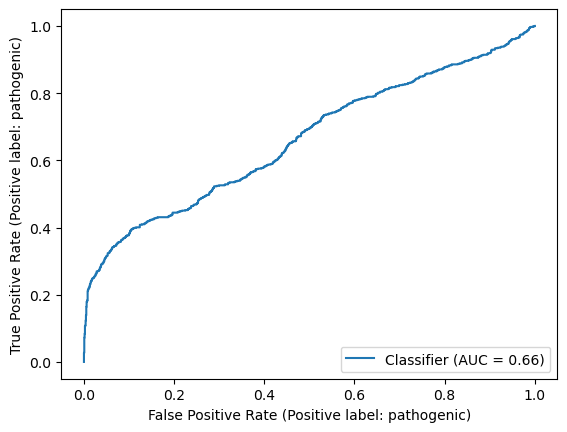

In [19]:
roccurve = RocCurveDisplay.from_predictions(y_true=clinvar_preds['significance'],
                                            y_pred=clinvar_preds['effect'],
                                            pos_label="pathogenic",
                                            )
plt.show()

In [20]:
fpr, tpr, ths = roc_curve(y_true=clinvar_preds['significance'],
                          y_score=clinvar_preds['effect'],
                          pos_label="pathogenic")

In [21]:
end = np.where(fpr>=0.01)[0][0]
assert end > 1
selected_th = ths[end-1] 

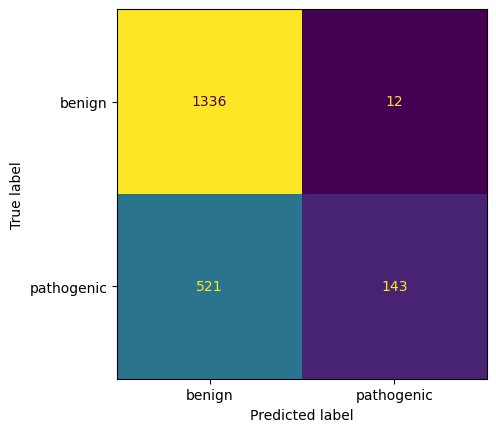

In [22]:
ConfusionMatrixDisplay.from_predictions(y_true=clinvar_preds['significance'],
                                        y_pred=np.where(clinvar_preds['effect'] >= selected_th, 'pathogenic', 'benign'),
                                       colorbar=False)
                                        

In [23]:
y_true = clinvar_preds['significance'] == "pathogenic"
y_pred = clinvar_preds['effect'] >= selected_th
print("Precision:", 
      precision_score(y_true=y_true,
                      y_pred=y_pred))
print("Recall:", 
      recall_score(y_true=y_true,
                   y_pred=y_pred))
print("F1-score:", 
      recall_score(y_true=y_true,
                   y_pred=y_pred))   

Precision: 0.9225806451612903
Recall: 0.21536144578313254
F1-score: 0.21536144578313254


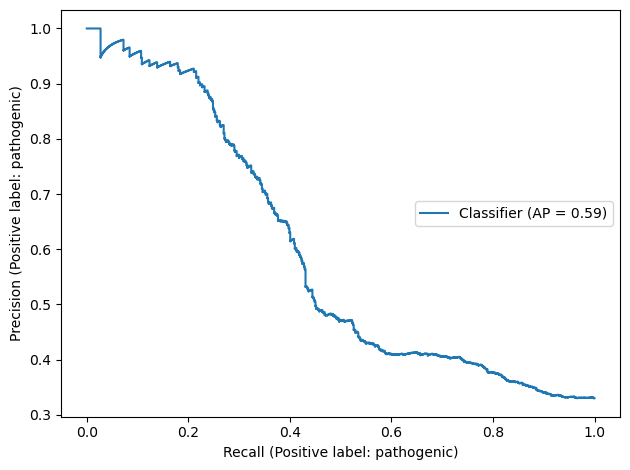

In [24]:
prcurve = PrecisionRecallDisplay.from_predictions(y_true=clinvar_preds['significance'],
                                            y_pred=clinvar_preds['effect'],
                                            pos_label="pathogenic")
plt.tight_layout()
plt.legend(loc=5)
plt.show()

In [25]:
precision, recall, ths = precision_recall_curve(y_true=clinvar_preds['significance'],
                                                probas_pred=clinvar_preds['effect'],
                                                pos_label="pathogenic")

In [26]:
selected_th = ths[np.argmin(np.abs(precision - 0.90))]

In [27]:
y_true = clinvar_preds['significance'] == "pathogenic"
y_pred = clinvar_preds['effect'] >= selected_th
print("Precision:", 
      precision_score(y_true=y_true,
                      y_pred=y_pred))
print("Recall:", 
      recall_score(y_true=y_true,
                   y_pred=y_pred))
print("F1-score:", 
      recall_score(y_true=y_true,
                   y_pred=y_pred))   

Precision: 0.8988095238095238
Recall: 0.22740963855421686
F1-score: 0.22740963855421686


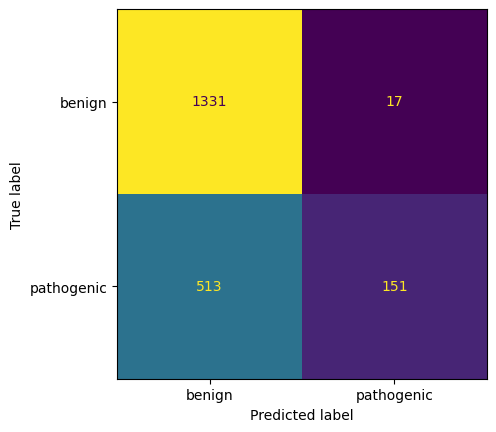

In [28]:
ConfusionMatrixDisplay.from_predictions(y_true=clinvar_preds['significance'],
                                        y_pred=np.where(clinvar_preds['effect'] >= selected_th, 'pathogenic', 'benign'),
                                        colorbar=False)
                                        